# Importing Libraries

### Libraries

In [29]:
import pandas as pd
import numpy as np
import warnings

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sv
from skopt import gp_minimize

from IPython.display            import Markdown

from sklearn.preprocessing      import LabelEncoder
from sklearn.ensemble           import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model       import LogisticRegression
from sklearn.neighbors          import KNeighborsClassifier
from sklearn.model_selection    import train_test_split, KFold
from sklearn.metrics            import roc_auc_score, accuracy_score
from sklearn.feature_selection  import SelectKBest, chi2
from skopt import dummy_minimize

### Auxiliary Functions and Configurations

In [4]:
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.2f}'.format
plt.style.use('ggplot')

def func_LabelEncoder(df):
    return LabelEncoder().fit_transform(df)

def LazzyLabelEncoder(df, text=True):
    text_LazzyLabelEncoder = ''
    dicio_LazzyLabelEncoder = {}
    for i, j in enumerate(df.unique()):
        text_LazzyLabelEncoder += f'{i} - {j}\n '
        dicio_LazzyLabelEncoder[j] = i
    return text_LazzyLabelEncoder[:-2] if text==True else dicio_LazzyLabelEncoder

def df_informations(df):
    df_info = pd.DataFrame({'Not Null': df.notnull().count(),
                'Null': df.isnull().sum(),
                'Perce Null': df.isnull().sum() / len(df),
                'Dtype': df.dtypes,
                })

    df_dtype = pd.DataFrame(df_info['Dtype'].value_counts())
    df_dtype['Perce'] = round(df_dtype['Dtype'] / df_dtype['Dtype'].sum(), 2)

    text = f'Dataset has {df.shape[0]} rows and {df.shape[1]} columns. From these, we have:'

    df_info = df_info.style.background_gradient(cmap='jet', subset=['Perce Null']).format({'Perce Null': '{:.2%}'})
    df_dtype = df_dtype.style.background_gradient(cmap='YlGn', subset=['Perce']).format({'Perce': '{:.2%}'})

    display(Markdown("<H3 style='text-align:left;float:lfet;'>Information about the Dataset"))
    display(Markdown(f'<H5> {text}'))
    display(df_info)
    display(Markdown("<H3 style='text-align:left;float:lfet;'>About Dtypes we have:"))
    display(df_dtype)

# Data Understanding

## Collect  Initial Data

In [5]:
df = pd.read_csv('bank_customer_churn_prediction.csv')
df_sv = df.copy()
df

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15606229,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,15569892,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,15584532,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,15682355,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


## Describe Data

The dataset collected from Kaggle (https://www.kaggle.com/datasets/gauravtopre/bank-customer-churn-dataset?resource=download).

- customer_id, <font color='red'>unused variable</font>.
- credit_score, <font color='chartreuse'>used as input</font>.
- country, <font color='chartreuse'>used as input</font>.
- gender, <font color='chartreuse'>used as input</font>.
- age, <font color='chartreuse'>used as input</font>.
- tenure, <font color='chartreuse'>used as input</font>.
- balance, <font color='chartreuse'>used as input</font>.
- products_number, <font color='chartreuse'>used as input</font>.
- credit_card, <font color='chartreuse'>used as input</font>.
- active_member, <font color='chartreuse'>used as input</font>.
- estimated_salary, <font color='chartreuse'>used as input</font>.
- churn, <font color='orange'>used as the target</font>. 1 if the client has left the bank during some period or 0 if he/she has not.

Dropping the customer_id column

In [6]:
df = df.drop(['customer_id'], axis=1)

Data Information

In [7]:
df_informations(df)

<H3 style='text-align:left;float:lfet;'>Information about the Dataset

<H5> Dataset has 10000 rows and 11 columns. From these, we have:

,Not Null,Null,Perce Null,Dtype
credit_score,10000,0,0.00%,int64
country,10000,0,0.00%,object
gender,10000,0,0.00%,object
age,10000,0,0.00%,int64
tenure,10000,0,0.00%,int64
balance,10000,0,0.00%,float64
products_number,10000,0,0.00%,int64
credit_card,10000,0,0.00%,int64
active_member,10000,0,0.00%,int64
estimated_salary,10000,0,0.00%,float64


<H3 style='text-align:left;float:lfet;'>About Dtypes we have:

,Dtype,Perce
int64,7,64.00%
object,2,18.00%
float64,2,18.00%


In [8]:
df.describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.99]).T

,count,mean,std,min,1%,25%,50%,75%,99%,max
credit_score,10000.00,650.53,96.65,350.00,432.00,584.00,652.00,718.00,850.00,850.00
age,10000.00,38.92,10.49,18.00,21.00,32.00,37.00,44.00,72.00,92.00
tenure,10000.00,5.01,2.89,0.00,0.00,3.00,5.00,7.00,10.00,10.00
balance,10000.00,76485.89,62397.41,0.00,0.00,0.00,97198.54,127644.24,185967.99,250898.09
products_number,10000.00,1.53,0.58,1.00,1.00,1.00,1.00,2.00,3.00,4.00
credit_card,10000.00,0.71,0.46,0.00,0.00,0.00,1.00,1.00,1.00,1.00
active_member,10000.00,0.52,0.50,0.00,0.00,0.00,1.00,1.00,1.00,1.00
estimated_salary,10000.00,100090.24,57510.49,11.58,1842.83,51002.11,100193.91,149388.25,198069.73,199992.48
churn,10000.00,0.20,0.40,0.00,0.00,0.00,0.00,0.00,1.00,1.00


## Explore Data

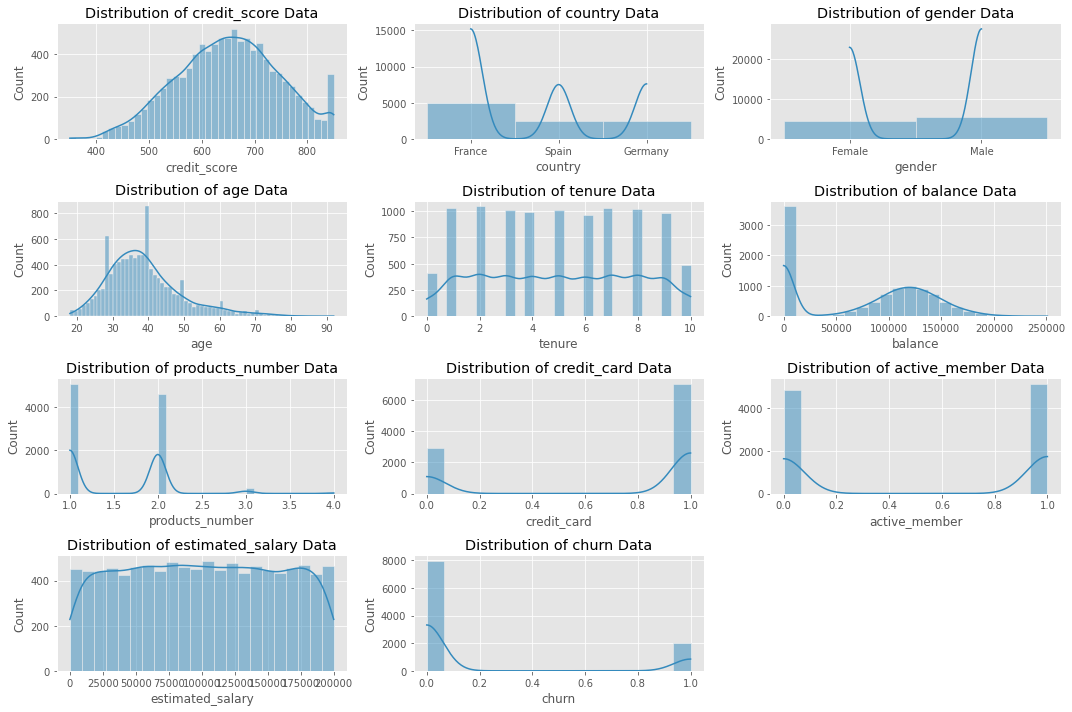

In [7]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(df.columns, 1):
    plt.subplot(4,3,i)
    plt.title(f"Distribution of {col} Data")
    sns.histplot(df[col], kde=True)
    plt.tight_layout()
    plt.plot()

Transforming Categorical Features into Numerical

In [9]:
dflazzy = df.copy()
choice_columns = ['country', 'gender']
for i in dflazzy[choice_columns]:
    dicio_encoder = LazzyLabelEncoder(df=dflazzy[i], text=False)
    dflazzy[str(i) + '_encoder'] = dflazzy[i].apply(lambda x: dicio_encoder.get(x))


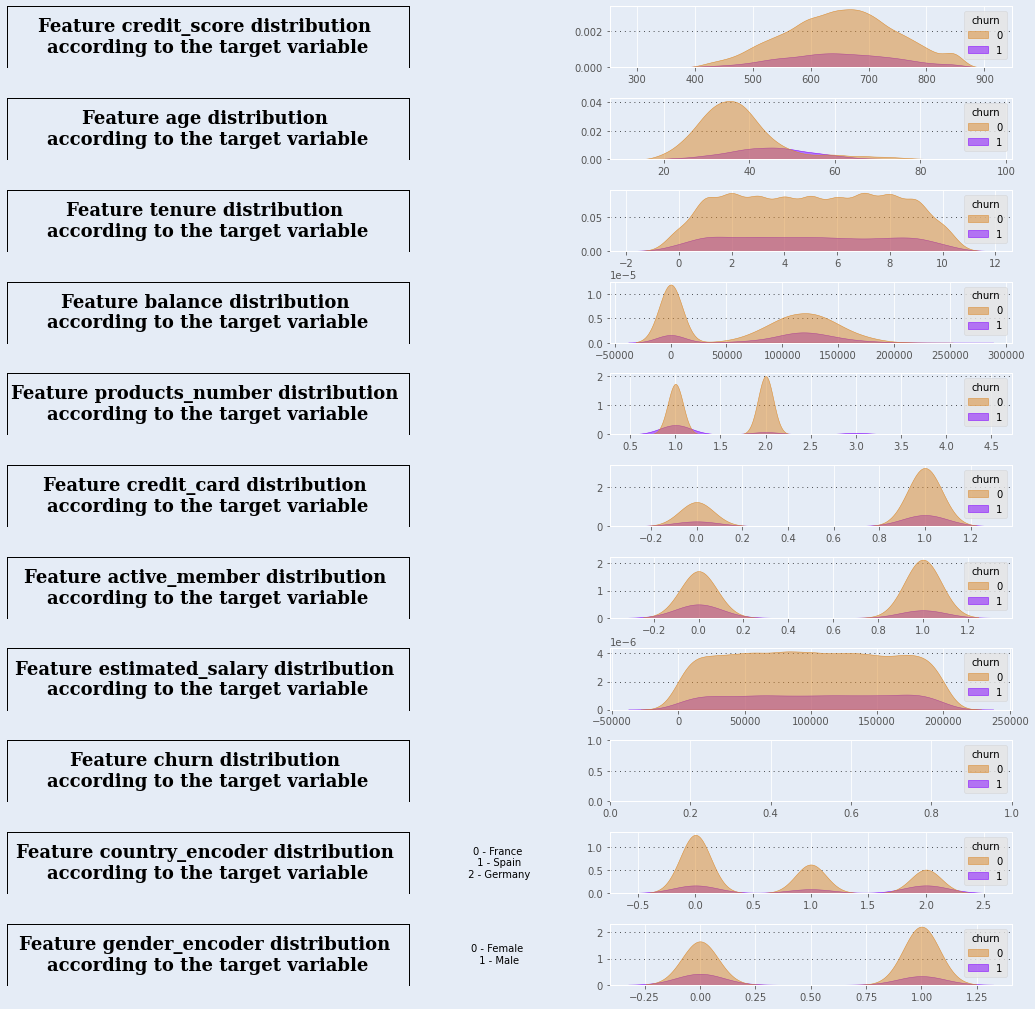

In [10]:
count_columns = dflazzy.select_dtypes(include= np.number).shape[1]

fig = plt.figure(figsize=(18,18))
gs = fig.add_gridspec(count_columns, 2)
gs.update(wspace=0.5, hspace=0.5)

background_color = "#E5ECF6"

for i, j in enumerate(dflazzy.select_dtypes(include= np.number)):
    
    legends = ''
    legends = LazzyLabelEncoder(df=dflazzy[j[:-8] if '_encoder' in j else j], text=True) if '_encoder' in j else ''

    globals()['axe' + str(i)] = fig.add_subplot(gs[i, 0])
    globals()['axe' + str(i+1)] = fig.add_subplot(gs[i, 1])

    fig.patch.set_facecolor(background_color) 
    globals()['axe' + str(i)].set_facecolor(background_color) 
    globals()['axe' + str(i+1)].set_facecolor(background_color) 

    globals()['axe' + str(i)].text(0.5, 0.5, f"Feature {j} distribution \naccording to the target variable",
        horizontalalignment = 'center', verticalalignment = 'center',
        fontsize = 18, fontweight='bold', fontfamily='serif',
        color='#000000')

    globals()['axe' + str(i)].grid(False)
    globals()['axe' + str(i)].spines["bottom"].set_visible(False)
    globals()['axe' + str(i)].spines[['left', 'top', 'right']].set_color('#000000')
    globals()['axe' + str(i)].set_xticklabels([])
    globals()['axe' + str(i)].set_yticklabels([])
    globals()['axe' + str(i)].tick_params(left=False, bottom=False)
    globals()['axe' + str(i)].text(1.22, 0.5, legends,
        horizontalalignment = 'center', verticalalignment = 'center', fontsize = 10
        )

    globals()['axe' + str(i+1)].grid(color='#000000', axis='y', zorder=0,  dashes=(1,5))
    sns.kdeplot(ax=globals()['axe' + str(i+1)], data=dflazzy, x=j, hue="churn", fill=True, palette=["#da8829", "#8000ff"], alpha=.5)
    globals()['axe' + str(i+1)].set_xlabel("")
    globals()['axe' + str(i+1)].set_ylabel("")


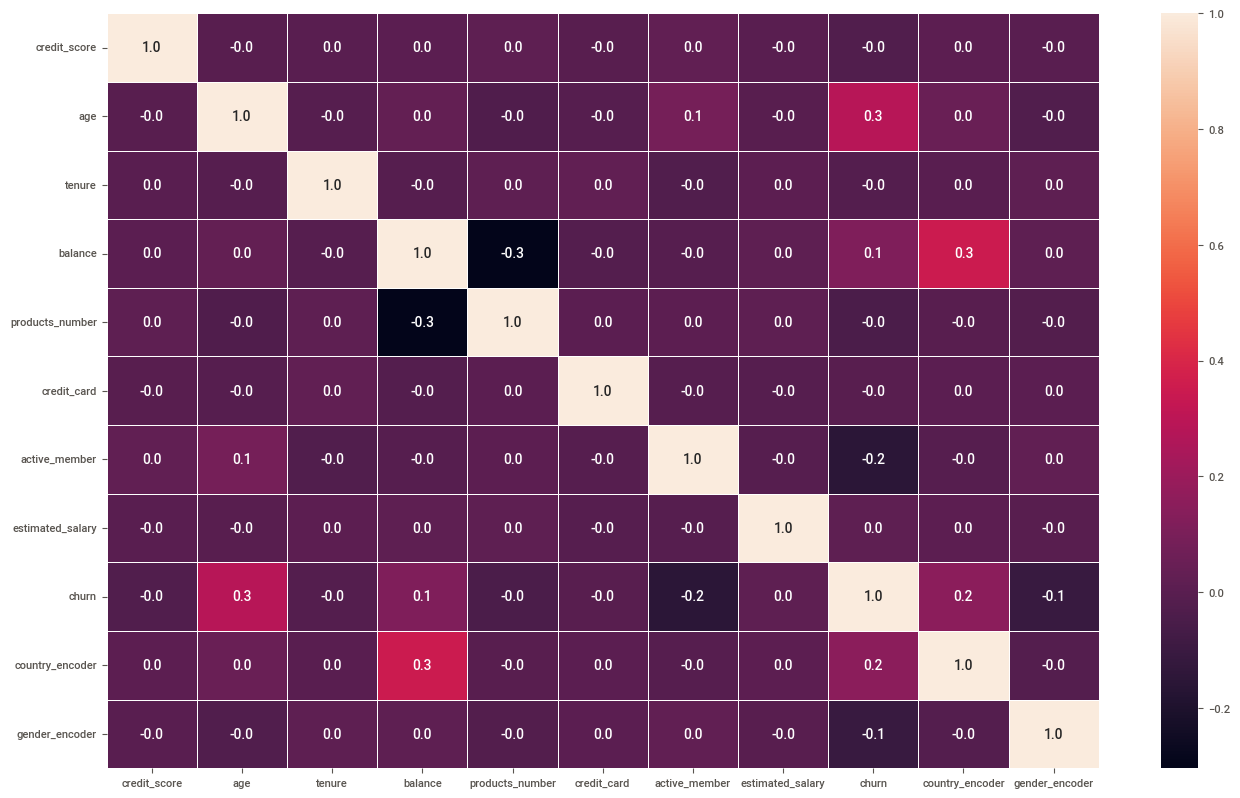

In [41]:
fig = plt.figure(figsize=(16,10))
correlation = dflazzy.corr() 
plot = sns.heatmap(correlation, annot = True, fmt=".1f", linewidths=.6)
plot;

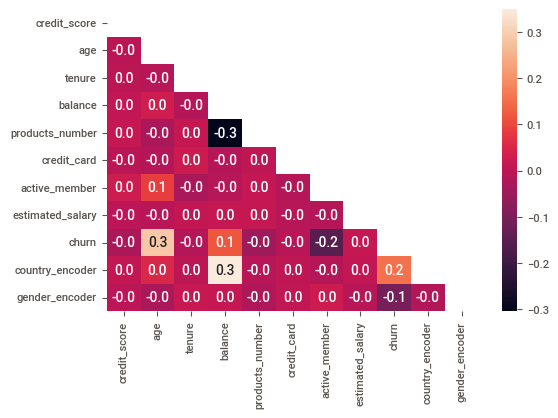

In [43]:
correlation = dflazzy.corr().transpose()
mask = np.triu(np.ones_like(correlation))
sns.heatmap(correlation,mask=mask,fmt=".1f",annot=True)
plt.show()

In [39]:
pd.DataFrame(correlation)

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,country_encoder,gender_encoder
credit_score,1.00,-0.00,0.00,0.01,0.01,-0.01,0.03,-0.00,-0.03,0.01,-0.00
age,-0.00,1.00,-0.01,0.03,-0.03,-0.01,0.09,-0.01,0.29,0.05,-0.03
tenure,0.00,-0.01,1.00,-0.01,0.01,0.02,-0.03,0.01,-0.01,0.00,0.01
balance,0.01,0.03,-0.01,1.00,-0.30,-0.01,-0.01,0.01,0.12,0.35,0.01
products_number,0.01,-0.03,0.01,-0.30,1.00,0.00,0.01,0.01,-0.05,-0.01,-0.02
credit_card,-0.01,-0.01,0.02,-0.01,0.00,1.00,-0.01,-0.01,-0.01,0.00,0.01
active_member,0.03,0.09,-0.03,-0.01,0.01,-0.01,1.00,-0.01,-0.16,-0.01,0.02
estimated_salary,-0.00,-0.01,0.01,0.01,0.01,-0.01,-0.01,1.00,0.01,0.01,-0.01
churn,-0.03,0.29,-0.01,0.12,-0.05,-0.01,-0.16,0.01,1.00,0.15,-0.11
country_encoder,0.01,0.05,0.00,0.35,-0.01,0.00,-0.01,0.01,0.15,1.00,-0.02


## Exploratory Data Analysis - SweetViz

In [12]:
my_report = sv.analyze(df_sv)
my_report.show_html()

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)


Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


# Data Preparation

## Select Data

In [14]:
# Aplicando a função LabelEncoder para transformar as colunas gender e country.
df['gender'] = func_LabelEncoder(df['gender'])
df['country'] = func_LabelEncoder(df['country'])

In [15]:
X = df.drop(columns='churn')
y = df['churn']
X_treino, X_valid, y_treino, y_valid = train_test_split(X, y, test_size=0.3, random_state=0)

In [16]:
KBest = SelectKBest(chi2, k=8)
fit = KBest.fit(X, y)
cols = fit.get_support(indices=True)
fit.transform(X)

array([[6.1900000e+02, 0.0000000e+00, 0.0000000e+00, ..., 1.0000000e+00,
        1.0000000e+00, 1.0134888e+05],
       [6.0800000e+02, 2.0000000e+00, 0.0000000e+00, ..., 1.0000000e+00,
        1.0000000e+00, 1.1254258e+05],
       [5.0200000e+02, 0.0000000e+00, 0.0000000e+00, ..., 3.0000000e+00,
        0.0000000e+00, 1.1393157e+05],
       ...,
       [7.0900000e+02, 0.0000000e+00, 0.0000000e+00, ..., 1.0000000e+00,
        1.0000000e+00, 4.2085580e+04],
       [7.7200000e+02, 1.0000000e+00, 1.0000000e+00, ..., 2.0000000e+00,
        0.0000000e+00, 9.2888520e+04],
       [7.9200000e+02, 0.0000000e+00, 0.0000000e+00, ..., 1.0000000e+00,
        0.0000000e+00, 3.8190780e+04]])

In [19]:
df.iloc[:, cols]

,credit_score,country,gender,age,balance,products_number,active_member,estimated_salary
0,619,0,0,42,0.00,1,1,101348.88
1,608,2,0,41,83807.86,1,1,112542.58
2,502,0,0,42,159660.80,3,0,113931.57
3,699,0,0,39,0.00,2,0,93826.63
4,850,2,0,43,125510.82,1,1,79084.10
...,...,...,...,...,...,...,...,...
9995,771,0,1,39,0.00,2,0,96270.64
9996,516,0,1,35,57369.61,1,1,101699.77
9997,709,0,0,36,0.00,1,1,42085.58
9998,772,1,1,42,75075.31,2,0,92888.52


In [17]:
from sklearn.metrics import accuracy_score
from skopt import dummy_minimize #Random Search

In [22]:
def treinar_modelo(params): #Random Search
    max_depth = params[0]
    n_jobs = params[1]
    max_leaf_nodes = params[2]
    max_samples = params[3]

    print(params, '\n')
    

    mdl = RandomForestClassifier(max_depth=max_depth, n_jobs=n_jobs, 
                                max_leaf_nodes=max_leaf_nodes, 
                                max_samples=max_samples, n_estimators=500, random_state=0)

    mdl.fit(X_treino, y_treino)

    p = mdl.predict_proba(X_valid)[:, 1]

    return -roc_auc_score(y_valid, p)


space = [(1, 8), # max_depth
        (1, 11), # n_jobs
        (2, 30), # max_leaf_nodes
        (1, 16)] # max_samples
resultado = dummy_minimize(treinar_modelo, space, n_calls=20, random_state=0, verbose = 1)


Iteration No: 1 started. Evaluating function at random point.
[8, 6, 2, 4] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.2347
Function value obtained: -0.7799
Current minimum: -0.7799
Iteration No: 2 started. Evaluating function at random point.
[4, 4, 9, 10] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.8291
Function value obtained: -0.7852
Current minimum: -0.7852
Iteration No: 3 started. Evaluating function at random point.
[4, 6, 20, 5] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.8812
Function value obtained: -0.7814
Current minimum: -0.7852
Iteration No: 4 started. Evaluating function at random point.
[8, 7, 26, 9] 

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.8385
Function value obtained: -0.7883
Current minimum: -0.7883
Iteration No: 5 started. Evaluating function at random point.
[5, 11, 3, 7] 

Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.8262
Func

In [24]:
resultado.x

[1, 5, 19, 16]

In [25]:
result = []
for repet in range(15): #Cross Validation
    print('Repetição: ', repet)
    kf1 = KFold(3, shuffle=True, random_state=repet)

    for linhas_treino, linhas_valid in kf1.split(X, groups=None):
        print("Treino", linhas_treino.shape[0]) 
        print("Valid", linhas_valid.shape[0])

        X_treino, X_valid = X.iloc[linhas_treino], X.iloc[linhas_valid]
        y_treino, y_valid = y.iloc[linhas_treino], y.iloc[linhas_valid]

        modelo_b = RandomForestClassifier(max_depth = resultado.x[0],
                                          n_jobs = resultado.x[1],
                                          max_leaf_nodes = resultado.x[2],
                                          max_samples = resultado.x[3],
                                          n_estimators=500, random_state=repet)
        print('Repetição:',repet)
        modelo_b.fit(X_treino, y_treino)

        p = modelo_b.predict(X_valid)
        result.append(roc_auc_score(y_valid, p))
        acc1 = np.mean(p == y_valid)
        result.append(acc1)
        print('Acurácia:', acc1)
        print()

Repetição:  0
Treino 6666
Valid 3334
Repetição: 0
Acurácia: 0.7936412717456509

Treino 6667
Valid 3333
Repetição: 0
Acurácia: 0.8025802580258026

Treino 6667
Valid 3333
Repetição: 0
Acurácia: 0.7926792679267927

Repetição:  1
Treino 6666
Valid 3334
Repetição: 1
Acurácia: 0.7915416916616677

Treino 6667
Valid 3333
Repetição: 1
Acurácia: 0.7941794179417941

Treino 6667
Valid 3333
Repetição: 1
Acurácia: 0.8031803180318032

Repetição:  2
Treino 6666
Valid 3334
Repetição: 2
Acurácia: 0.8029394121175765

Treino 6667
Valid 3333
Repetição: 2
Acurácia: 0.7884788478847885

Treino 6667
Valid 3333
Repetição: 2
Acurácia: 0.7974797479747975

Repetição:  3
Treino 6666
Valid 3334
Repetição: 3
Acurácia: 0.7948410317936413

Treino 6667
Valid 3333
Repetição: 3
Acurácia: 0.7938793879387939

Treino 6667
Valid 3333
Repetição: 3
Acurácia: 0.8001800180018002

Repetição:  4
Treino 6666
Valid 3334
Repetição: 4
Acurácia: 0.8026394721055788

Treino 6667
Valid 3333
Repetição: 4
Acurácia: 0.7965796579657966

Treino

In [27]:
np.mean(result)

0.648150046958305

## Clean Data

## Construct Data

## Integrate Data

## Format Data

# Modeling

## Select Modeling Techniques

In [30]:
modelo = ExtraTreesClassifier()
modelo.fit(X,y)

ExtraTreesClassifier()

In [31]:
print(df.columns[0:10])
print(modelo.feature_importances_)

Index(['credit_score', 'country', 'gender', 'age', 'tenure', 'balance',
       'products_number', 'credit_card', 'active_member', 'estimated_salary'],
      dtype='object')
[0.13375625 0.04412994 0.01647112 0.24012261 0.10523209 0.12837406
 0.1425297  0.02182903 0.03449094 0.13306425]


In [32]:
feature_importance = pd.DataFrame(modelo.feature_importances_,
                                  index= df.columns[0:10],
                                  columns= ['importance']).sort_values('importance', ascending = False)

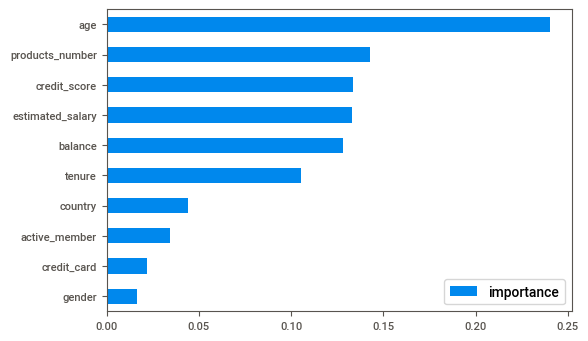

In [33]:
feature_importance.sort_values('importance').plot(kind='barh');

## Generate Test Design

## Build Model

## Assess Model

# Evaluation

## Evaluate Results

## Review Process

## Determine Next Steps

# Deployment

## Plan Deployment

## Plan Monitoring and Maintenance

## Produce Final Report

## Produce Final Report

## Review Project